In [1]:
### Solve Heat Equation

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.testing as nptest
import scipy.sparse as sparse
import scipy.sparse.linalg as sparselinalg

In [180]:
def u(x,y): return x**4*y**5-17*np.sin(x*y)

In [80]:
def phi(x,y): return 12*x**2*y**5+20*x**4*y**3+(x**2+y**2)*17*np.sin(x*y)

In [2]:
#generate mesh, i.e. x_i,y_i (including the boundary)
# our n ranges from 2 to 8, i.e. if n=2, we have h_x=h_y=1/4
# if h=2**(-n), then there are 2**n+1 grid points in each direction

def meshvector(n):
    h=2**(-n)
    pts=2**n-1
    x=np.zeros((pts**2,2))
    # print(len(x))
    for j in range(pts):
        for i in range(pts):
            x[pts*j+i,0]=(i+1)*h
            x[pts*j+i,1]=(j+1)*h
            # print((i,j))
            # print(x[n*j+i,:])
    return x

In [17]:
assert meshvector(5).shape == ((2**5-1)**2,2)
assert (meshvector(5)[0] == [1/2**5,1/2**5]).all() 

In [150]:
def fgrid(n):
    N = 2**n-1
    h = 2**(-n)
    x = meshvector(n)
    fgrid = np.ones(x.shape[0])*np.inf
    fgrid = phi(x[:,0],x[:,1])
    
    fgrid[:N] += 1/(h**2)*(-u(x[:N,0]-h, x[:N,1]-h) + 2* u(x[:N,0],x[:N,1]-h) - u(x[:N,0]+h, x[:N,1]-h))
    fgrid[-N:] += 1/(h**2)*(-u(x[-N:,0]-h, x[-N,1]+h) + 2 * u(x[-N:,0], x[-N,1]+h) -u(x[-N:,0]+h, x[-N,1]+h))
    fgrid[::N] += 1/(h**2)*(-u(x[::N,0]-h, x[::N,1]-h) + 2 * u(x[::N,0]-h, x[::N,1]) -u(x[::N,0]-h, x[::N,1]+h))
    fgrid[N-1::N] += 1/(h**2)*(-u(x[N-1::N,0]+h, x[N-1::N,1]-h) + 
                              2 * u(x[N-1::N,0]+h, x[N-1::N,1]) -
                              u(x[N-1::N,0]+h, x[N-1::N,1]+h))
    return fgrid

## Constructing the 9-Point-Stencil Operator

In [59]:
def BpartA(n):
    h=1/2**n
    N=2**n-1
    data=[[-2/h**2]*(N)**2, [4/h**2]*(N)**2, [-2/h**2]*(N)**2]
    offsets = np.array([-1,0,1])
    b = sparse.dia_matrix((data, offsets),shape=(N,N)).toarray() 
    bmultiple = (b,)*(N)
    return sparse.block_diag(bmultiple).toarray()

In [60]:
def tmpCpartA(n):
    h=1/2**n
    N=2**n-1
    data=[[1/h**2]*(N)**2, [-2/h**2]*(N)**2, [1/h**2]*(N)**2]
    offsets = np.array([-1,0,1])
    b = sparse.dia_matrix((data, offsets),shape=(N,N)).toarray() 
    bmultiple = (b,)*(N)
    return sparse.block_diag(bmultiple).toarray()

In [61]:
def createA(n):
    N = 2**n-1
    C = tmpCpartA(n)
    upperC = np.zeros(C.shape)
    upperC[:,N:] = C[:,:-N]
    lowerC =  np.zeros(C.shape)
    lowerC[:,:-N] = C[:,N:]
    return BpartA(n)+upperC + lowerC

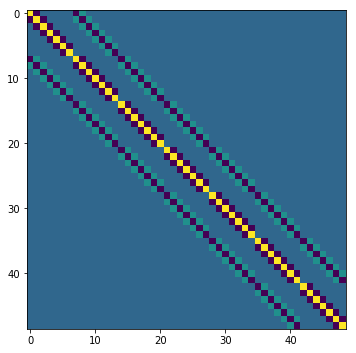

In [152]:
a = createA(3)
fig, ax = plt.subplots(figsize=(18, 5))
ax.imshow(np.array(a), interpolation='none')
plt.tight_layout()
b = sparse.coo_matrix(a)

In [172]:
def approximate_u(n):
    Lambda = createA(n)
    f = fgrid(n)
    return sparselinalg.spsolve(sparse.csc_matrix(Lambda),f)

In [190]:
n = 2
x = meshvector(n)
u_h = approximate_u(n)
u_real = u(x[:,0],x[:,1])
u_real
#u_h-u_real

array([-1.06180459, -2.11940943, -3.16854705, -2.1193484 , -4.20391418,
       -6.2167453 , -3.16792907, -6.21180145, -8.99106076])

In [191]:
u(0.5,0.5)

-4.2039141823268897

In [186]:
x = meshvector(2)
x

array([[ 0.25,  0.25],
       [ 0.5 ,  0.25],
       [ 0.75,  0.25],
       [ 0.25,  0.5 ],
       [ 0.5 ,  0.5 ],
       [ 0.75,  0.5 ],
       [ 0.25,  0.75],
       [ 0.5 ,  0.75],
       [ 0.75,  0.75]])